In [2]:
from typing_extensions import TypedDict
from pydantic import BaseModel,Field
from typing import Literal
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage,SystemMessage
import os
from dotenv import load_dotenv
load_dotenv()
from langgraph.graph import StateGraph, START,END

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

llm=ChatGroq(model="llama-3.1-8b-instant")


In [3]:
class Feedback(BaseModel):
    grade:Literal["funny","not_funny"]=Field(description="Decide if the joke is funny or not.")
    feedback:str=Field(description="If the joke is not funny, provide feedback on how to improve it.")

In [4]:
evl=llm.with_structured_output(Feedback)

In [6]:
class State(TypedDict):
    topic:str
    joke:str
    feedback:str
    funny_or_not:str

In [7]:
def llm_call_generator(state:State):
    '''Generae a joke '''
    if state.get('feedback'):
        msg=llm.invoke(f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}")
    else:
        msg=llm.invoke(f"Write a joke about {state['topic']}")

    return {"joke":msg.content}

In [8]:
def llm_call_evaluator(state:State):
    grade=evl.invoke(f'grade the joke {state['joke']}')
    return{"funny_or_not":grade.grade,"feedback":grade.feedback}

In [9]:
def route_joke(state:State):
    if state['funny_or_not']=="funny":
        return "Accepted"
    elif state["funny_or_not"]=="not_funny":
        return "Rejected + feedback"

In [10]:
graph=StateGraph(State)

graph.add_node("llm_call_generator",llm_call_generator)
graph.add_node("evaluator", llm_call_evaluator)

graph.add_edge(START,"llm_call_generator")
graph.add_edge("llm_call_generator","evaluator")
graph.add_conditional_edges("evaluator",route_joke,{"Accepted":END,"Rejected + feedback":"llm_call_generator"})

In [11]:
build_graph=graph.compile()

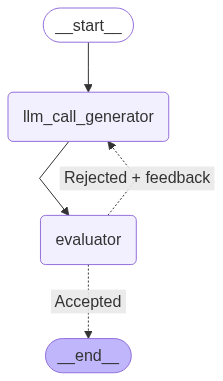

In [13]:
from IPython.display import Image,display
display(Image(build_graph.get_graph().draw_mermaid_png()))

In [17]:
state=build_graph.invoke({"topic":"AI News"})
state

{'topic': 'AI News',
 'joke': "Why did the AI-powered news anchor break up with its girlfriend?\n\nBecause it couldn't fact-check its emotions, and it kept spewing out fake news about their relationship.",
 'feedback': "The joke relies on a clever play on words, using the common phrase 'fact-check' and applying it to the AI's inability to check its emotions, and 'fake news' having a double meaning. It's a well-crafted pun that creates a humorous connection. To improve, consider varying the delivery or adding a twist to the punchline to keep it fresh.",
 'funny_or_not': 'funny'}

In [19]:
print(state["joke"])

Why did the AI-powered news anchor break up with its girlfriend?

Because it couldn't fact-check its emotions, and it kept spewing out fake news about their relationship.
